In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

def bplot(img):
    plt.figure(figsize=(20,10))
    plt.imshow(img,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def cplot(img):
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

38.567703650342814
95.73199723072985


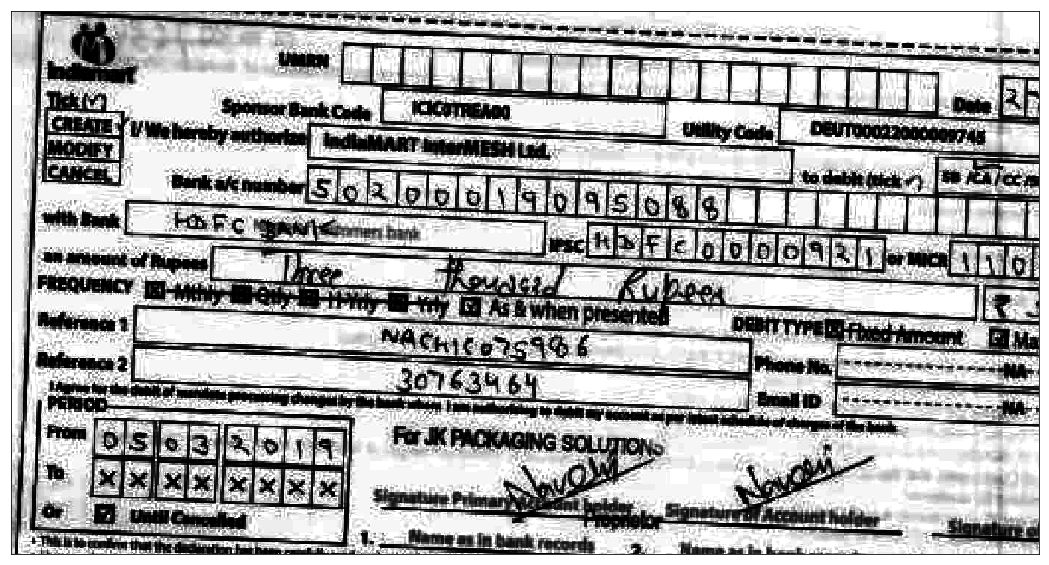

In [2]:
def adjust_gamma(image, gamma=1.0):
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                for i in np.arange(0, 256)]).astype("uint8")
 
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)

def crop(img):
    gray = 255 * (img < 128).astype(np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((5, 5), dtype=np.uint8)) # Perform noise filtering
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    max_padding = 50
    x_min_padding = 0 if x < max_padding else  max_padding
    y_min_padding = 0 if y < max_padding else  max_padding
    rect = img[y-y_min_padding:y+h+max_padding, x-x_min_padding:x_min_padding+x+w] # Crop the image - with 50 padding
    return rect

img = cv2.imread("/home/amidezcod/Downloads/VAULTEDGE/Nach/F_075986-1.jpg" , cv2.IMREAD_GRAYSCALE)
img = crop(img)
print(np.std(img))
img = adjust_gamma(img, gamma=0.11)
print(np.std(img))
bplot(img)

In [2]:
# bplot(img[285:330,222:225])
# img[285:330,222:225]


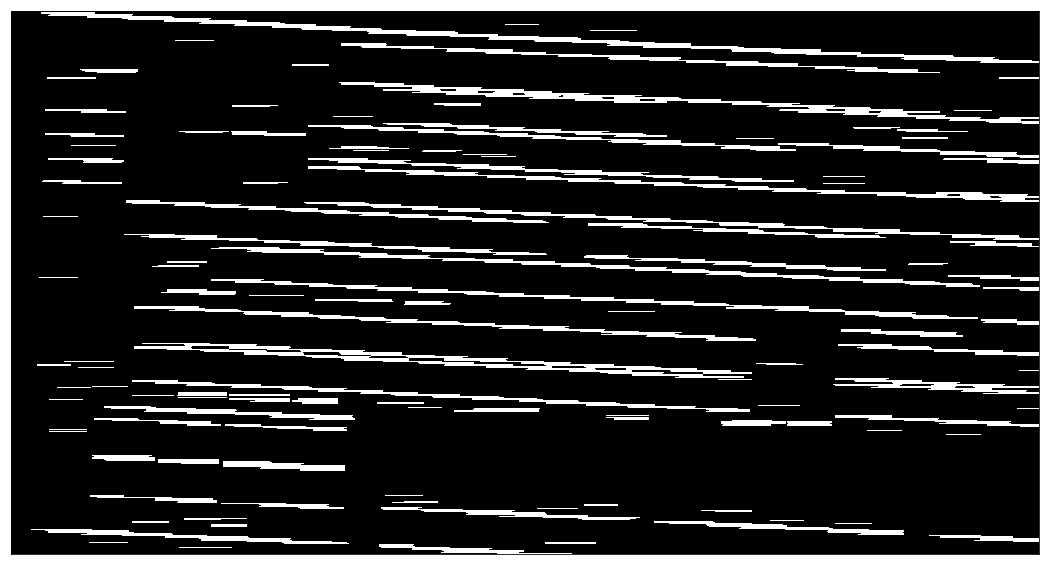

In [3]:
def horizontal(img):

    ## Generating Horizontal Mask

    
    horizontal = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,15)
    horizontalsize = horizontal.shape[1]  // 30
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT ,(horizontalsize,1) )
    horizontal =  cv2.morphologyEx(horizontal, cv2.MORPH_CLOSE, horizontalStructure)
    horizontal = np.where(horizontal==0,1,0)
    return horizontal

bplot(horizontal(img))

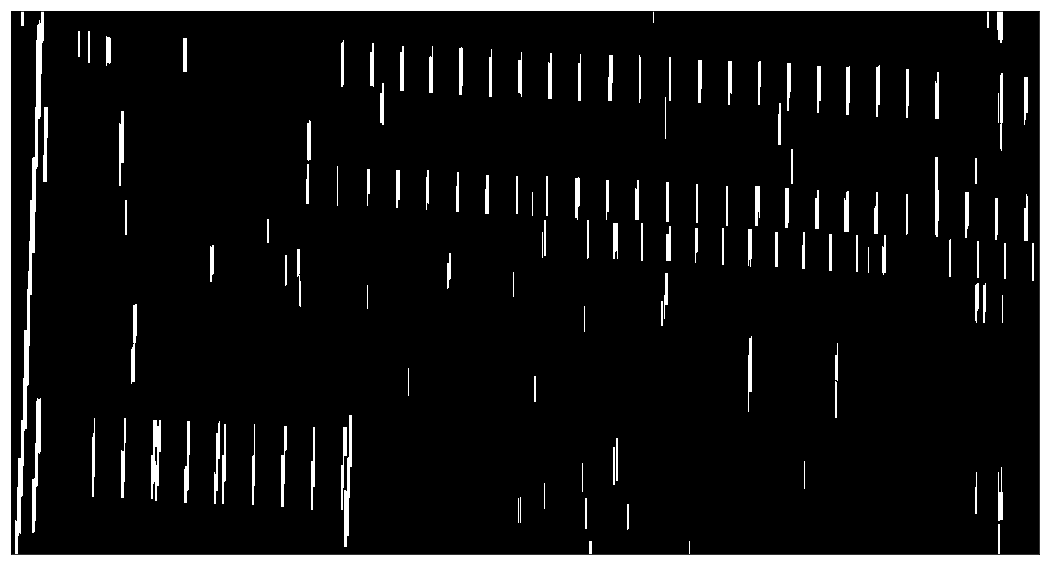

In [4]:
def vertical(img):

    # Generate Vertical Mask

    vertical = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 0.5);
    verticalsize = vertical.shape[0] // 22
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, ( 1,verticalsize))
    vertical =  cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, verticalStructure)
    vertical = np.where(vertical==0,1,0)
    return vertical
bplot(vertical(img))

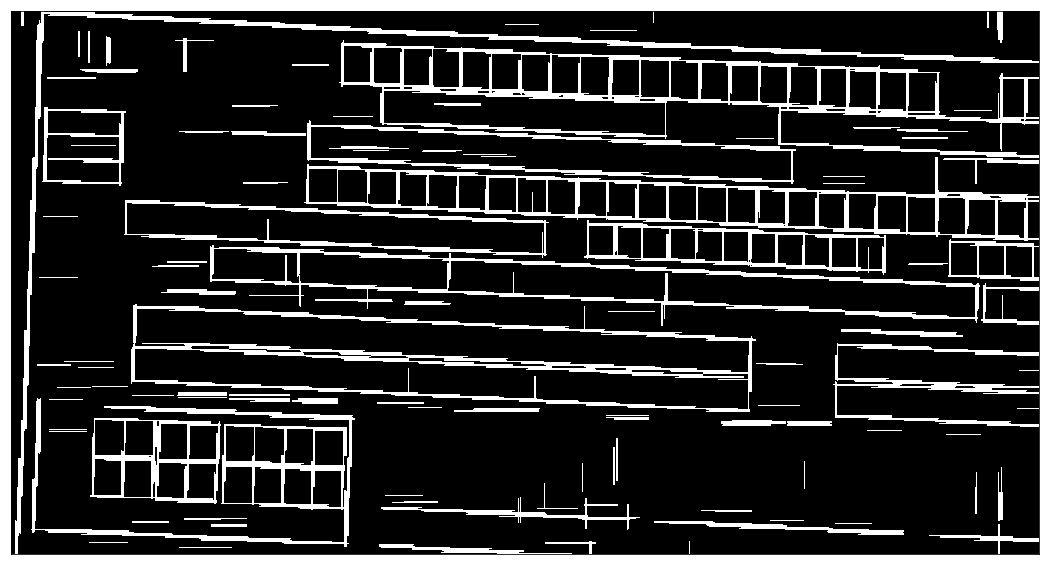

In [5]:
def generateCompleteMask(horizontal , vertical):
    mask = horizontal+vertical
    mask = np.where(mask>=1 ,255,mask)
    mask = mask.astype(np.uint8)
    return mask
bplot(generateCompleteMask(horizontal(img) , vertical(img)))

In [6]:
    rho = 1
    theta = np.pi/180
    threshold = 0
    min_line_length = 0
    max_line_gap = 5
    for file in inputdir.iterdir():
        img = cv2.imread(str(file) , cv2.IMREAD_GRAYSCALE)
        img = crop(img)
        gamma = 0.111 if img.std()>= 40 else 1.0
        imgg = adjust_gamma(img , gamma)
        mask =generateCompleteMask(horizontal(imgg) , vertical(imgg))

        # Run Hough on the edge-detected image
        lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

        # Iterate over the output "lines" and draw lines on the image copy
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),(255,255,255),3)
        img = cv2.GaussianBlur(img, (5,5), 0)
        img = cv2.resize(img ,  (1600,800))
        bplot(img)

In [93]:
df = pd.read_csv("data.csv");df

,name,gamma,before_mean,before_std,before_sum,after_mean,after_std,after_sum
0,NACH Form_edited-1.png,1.0,221.475257,38.953987,254343514,157.157734,81.930692,180480885
1,nach_scanner_output-5.jpg,0.2,232.704383,53.866077,155673647,211.738508,83.388749,141647980
2,nach_scanner_output-2.jpg,0.2,232.709361,53.725053,243321839,211.679459,83.421492,221332889
3,nach_scanner_output-3.jpg,0.2,226.084297,67.143539,13493163,209.565129,89.623866,12507266
4,nach_scanner_output-4.jpg,0.2,225.936302,67.068204,13517543,209.007889,89.991918,12504733
5,nach_scanner_output-1.jpg,0.2,234.024103,51.002288,257424173,212.938571,82.087252,234230299
6,nach.jpeg,1.0,231.053022,45.979837,616582317,194.404495,72.495715,518782976


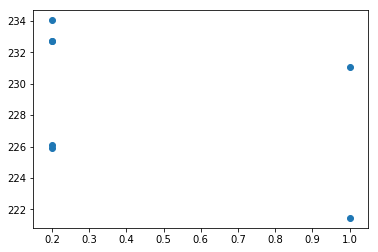

In [94]:
plt.scatter(df.gamma , df.before_mean)

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X = df.iloc[:,2:4].values
y = df.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [120]:
X_train, y_train, X_test,y_test

(array([[232.70438252,  53.86607726],
        [232.70936129,  53.72505315],
        [221.47525701,  38.95398718],
        [226.08429677,  67.14353927],
        [225.93630179,  67.06820445]]),
 array([0.2, 0.2, 1. , 0.2, 0.2]),
 array([[231.05302156,  45.97983731],
        [234.02410295,  51.00228758]]),
 array([1. , 0.2]))

In [118]:
reg = LinearRegression().fit(X_train,y_train )

In [119]:
reg.predict(X_test)

array([0.43900815, 0.20380431])

In [54]:
img = cv2.imread("/home/amidezcod/Downloads/VAULTEDGE/Nach/nachInput/F_076003-1.jpg" , cv2.IMREAD_GRAYSCALE)
img = cv2.GaussianBlur(img, (5,5), 0)

from PIL import ImageOps,Image
img = Image.fromarray(img)
img = ImageOps.expand(img, border=100, fill=255)
img = np.array(img)

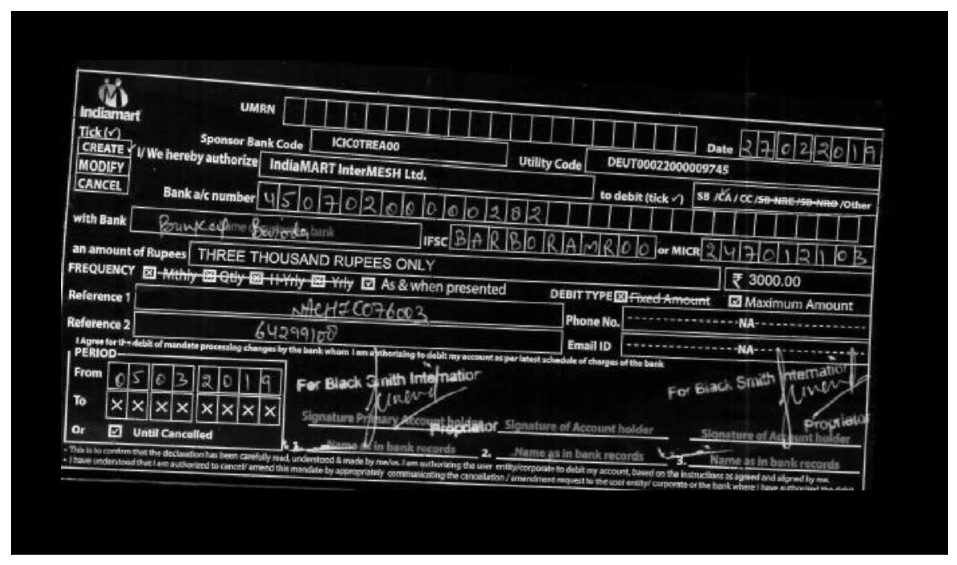

In [55]:
gray = cv2.bitwise_not(img)
bplot(gray)

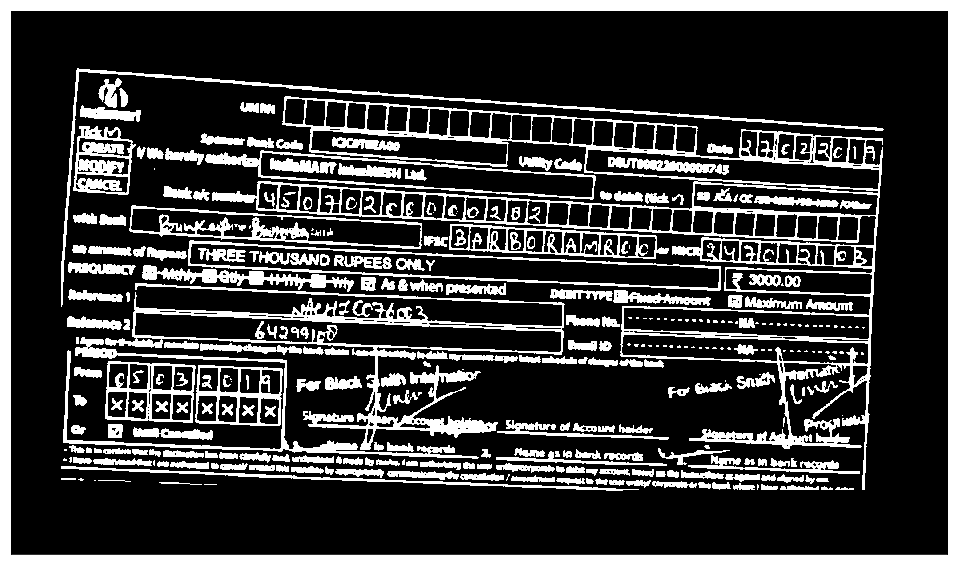

In [56]:
thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
bplot(thresh)

In [57]:
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
 
# the `cv2.minAreaRect` function returns values in the
# range [-90, 0); as the rectangle rotates clockwise the
# returned angle trends to 0 -- in this special case we
# need to add 90 degrees to the angle
if angle < -45:
	angle = -(90 + angle)
 
# otherwise, just take the inverse of the angle to make
# it positive
else:
	angle = -angle

In [58]:
angle

2.832111120223999

In [60]:
(h, w) = img.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

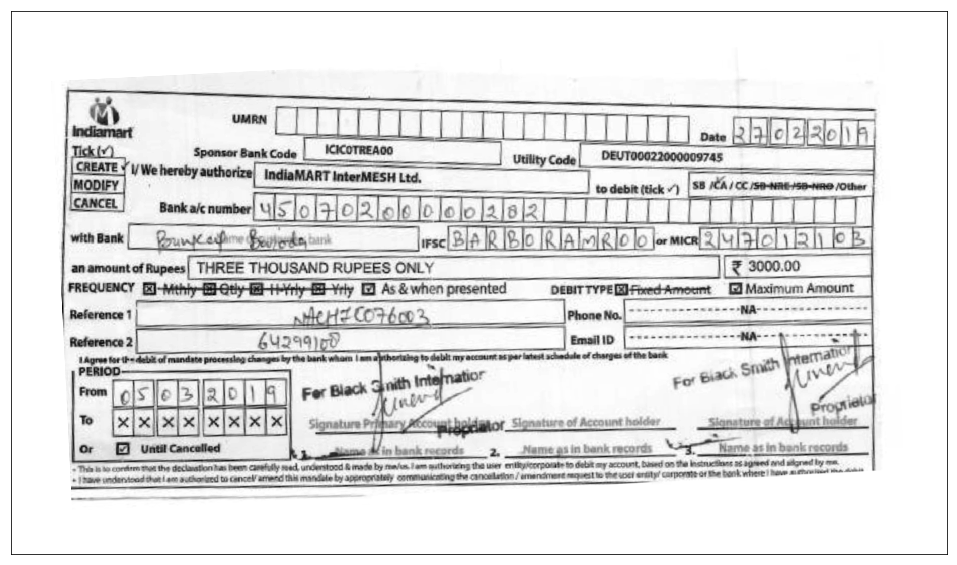

In [64]:
bplot(rotated)

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import sys
from PIL import Image,ImageOps

def bplot(img):
    plt.figure(figsize=(20,10))
    plt.imshow(img,cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()

def cplot(img):
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def horizontal(img):

    ## Generating Horizontal Mask

    horizontal = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15,15)
    horizontalsize = horizontal.shape[1]  // 25
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT ,(horizontalsize,1) )
    horizontal =  cv2.morphologyEx(horizontal, cv2.MORPH_CLOSE, horizontalStructure)
    horizontal = np.where(horizontal==0,1,0)
    return horizontal

def vertical(img):

    # Generate Vertical Mask

    vertical = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 0.5);
    verticalsize = vertical.shape[0] // 20
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, ( 1,verticalsize))
    vertical =  cv2.morphologyEx(vertical, cv2.MORPH_CLOSE, verticalStructure)
    vertical = np.where(vertical==0,1,0)
    return vertical


def generateCompleteMask(horizontal , vertical):
    mask = horizontal+vertical
    mask = np.where(mask>=1 ,255,mask)
    mask = mask.astype(np.uint8)
    return mask

def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255   for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def crop(img):
    gray = 255 * (img < 128).astype(np.uint8)
    gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, np.ones((2, 2), dtype=np.uint8)) # Perform noise filtering
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    max_padding = 50
    x_min_padding = 0 if x < max_padding else  max_padding
    y_min_padding = 0 if y < max_padding else  max_padding
    rect = img[y-y_min_padding:y+h+max_padding, x-x_min_padding:x_min_padding+x+w] # Crop the image - with 50 padding
    return rect

def rotate(img):
    img = Image.fromarray(img)
    img = ImageOps.expand(img, border=100, fill=255)
    img = np.array(img)
    gray = cv2.bitwise_not(img)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
     
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
     
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated = Image.fromarray(rotated)
    rotated = ImageOps.crop(rotated,border=110)
    return np.array(rotated)

def generateFinalImage(inputdir , outputdir):
    """
    inputdir : Path
    outputdir: Path
    """
    rho = 2
    theta = np.pi/180
    threshold = 0
    min_line_length = 0
    max_line_gap = 5
    for file in inputdir.iterdir():
        img = cv2.imread(str(file) , cv2.IMREAD_GRAYSCALE)
        img = crop(img.copy())
        img = rotate(img.copy())
        print(img.shape)
        gamma = 0.111 if img.std()>= 40 else 1.0
        imgg = adjust_gamma(img.copy() , gamma)
        mask =generateCompleteMask(horizontal(imgg) , vertical(imgg))

        # Run Hough on the edge-detected image
        lines = cv2.HoughLinesP(mask, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

        # Iterate over the output "lines" and draw lines on the image copy
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img,(x1,y1),(x2,y2),(255,255,255),3)
        img = cv2.GaussianBlur(img, (5,5), 1)
        if img.shape[0]>1600:
            img = cv2.resize(img ,  (1600,800))
        cv2.imwrite(str(outputdir/file.name) , img)

inputdir = Path("nachInput")
outputdir= Path("nachOutput")
for i in outputdir.iterdir():
    i.unlink()
generateFinalImage(inputdir , outputdir)

(820, 1591)
(817, 1599)
(815, 1597)
(782, 1555)
(812, 1583)
(820, 1570)
(753, 1493)
(800, 1565)
(841, 1613)
